# Resolution analysis

We exemplify how to compute resolution kernels and the formal resolution matrix for a 2D ert inversion.

In [85]:
from math import sqrt, pi
import numpy as np
import pygimli as pg
from pygimli.physics import ert
from pygimli.solver.leastsquares import lsqr, cgls

First, we load the gallery example and do a standard error estimation.

In [86]:
data = pg.getExampleData("ert/gallery.dat")
data.estimateError(0.02)

27/05/24 - 18:44:10 - pyGIMLi - INFO - Looking for ert/gallery.dat in gimli-org/example-data/
27/05/24 - 18:44:10 - pyGIMLi - INFO - Cache c:\Guenther.T\src\gimli\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 13): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\13633420947223655174


27/05/24 - 18:44:10 - pyGIMLi - INFO - Found 2 regions.
27/05/24 - 18:44:10 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
27/05/24 - 18:44:10 - pyGIMLi - INFO - Found 2 regions.
27/05/24 - 18:44:10 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
27/05/24 - 18:44:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/05/24 - 18:44:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/05/24 - 18:44:10 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1913 Cells: 3640 Boundaries: 2822
27/05/24 - 18:44:10 - pyGIMLi - INFO - Use median(data values)=204.445
27/05/24 - 18:44:10 - pyGIMLi - INFO - Created startmodel from forward operator: 511, min/max=204.445000/204.445000
27/05/24 - 18:44:10 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000028550791590>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000028550791680>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000285507915E0>
min/max (data): 84.65/367
min/max (error): 2%/2%
min/max (start model): 204/204
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  304.39
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   17.26 (dPhi = 93.95%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.80 (dPhi = 87.58%) lam: 10.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.80)                   #
################################################################################


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x28550857760>)

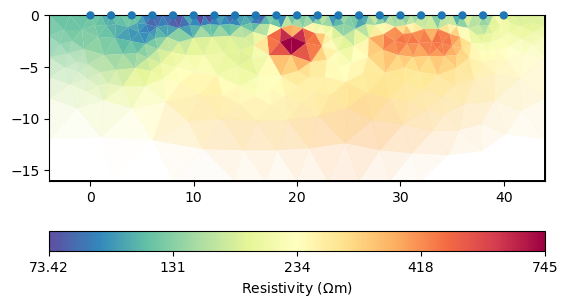

In [87]:
mgr = ert.Manager(data)
model = mgr.invert(lam=10, quality=34.4, verbose=True)
mgr.showResult()

In [88]:
# We save a few things for easier use as they might not come
# from a manager but an inversion instance.
inv = mgr.inv # inversion (no inv no resolution)
fop = mgr.fop # forward operator
mesh = mgr.paraDomain  # the inversion mesh
J = fop.jacobian()  # could also be load from disk
td = inv.dataTrans  # data transformation (e.g. lin/log/symlog)
tm = inv.modelTrans  # model transformation (typically log or logLU)
C = fop.constraints()  # (sparse) regularization matrix

In [89]:
# The Jacobian is the error-scaled sensitivity matrix,
# taking the transformation derivatives into account.
left = td.deriv(inv.response) / inv.errorVals
right = 1 / tm.deriv(model)
DS = pg.matrix.MultLeftRightMatrix(J, left, right)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2855d64bbb0>)

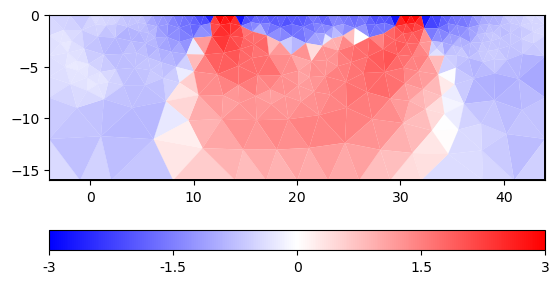

In [90]:
# Let us retrieve one column of the Jacobian matrix (works for all types)
# by multiplying with a zero data vector containing one element with 1.
# The number corresponds to the data index, result is the scaled Jacobian.
one = pg.Vector(len(inv.dataVals))
one[111] = 1
Jcol = DS.transMult(one)
pg.show(mesh, pg.math.symlog(Jcol, 1e-2), cMin=-3, cMax=3, cMap="bwr")

In [91]:
# Now we construct a block matrix of jacobian and regularization
# below each other.
JC = pg.BlockMatrix()
JC.addMatrix(DS, 0, 0)
JC.addMatrix(C, DS.rows(), 0, sqrt(inv.lam))
JC.recalcMatrixSize()
print(J.rows(), C.rows(), JC.rows(), JC.cols())

116 731 847 511


We now do the opposite and extract a column for a specific cell.
We put this into the inverse solver (eq. 2.50 in Günther, 2004).
and compute the corresponding resolution kernel.
The resolution radius is the radius of the equivalent circle assuming
a constant resolution kernel, i.e. circle_area*RM[i,i]=cell_size.
Note that for 3D eq. (2.46a) needs to be used.

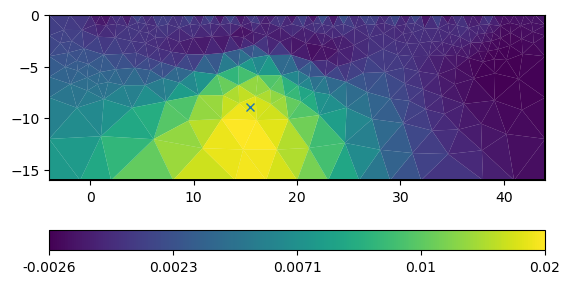

In [102]:
nr = 456
one = pg.Vector(len(model))
one[nr] = 1
Jrow = DS.mult(one)
invec = pg.cat(Jrow, pg.Vector(C.rows()))
reskernel = lsqr(JC, invec) # , maxiter=50)
resrad = (mesh.cell(nr).size()/reskernel[nr]/pi)**0.5
ax, cb = pg.show(mesh, reskernel)
ax.plot(mesh.cell(nr).center().x(), mesh.cell(nr).center().y(), "x");
pg.plt.Circle((mesh.cell(nr).center().x(), mesh.cell(nr).center().y()),
              resrad, color="magenta")

As the problem is small, we can compute the whole matrix.
We convert them to numpy.array and do the same scaling.

In [93]:
JJ = np.reshape(left, [-1, 1])*pg.utils.gmat2numpy(J)*np.reshape(right, [1, -1])
CC = pg.utils.sparseMat2Numpy.sparseMatrix2Dense(C)

Now we compute the formal resolution matrix (2.42).

In [94]:
JTJ = JJ.T.dot(JJ)
JI = np.linalg.inv(JTJ+CC.T.dot(CC)*inv.lam)
RM = JI.dot(JTJ)

Taking the diagonals of the resolution matrices, we can compute a resolution radius for every model cell and display it.

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x28536595ca0>)

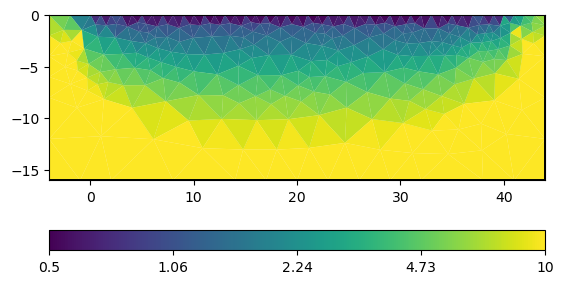

In [95]:
rm = np.diag(RM)
resolutionRadVec = np.abs(mesh.cellSizes()/rm/pi)**0.5
pg.show(mesh, resolutionRadVec, cMin=0.5, cMax=10, logScale=True)